In [2]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project='img_captioning', entity='adrgw')

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True
root_captioning = "C:/Users/Adi/Downloads/praca/"
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adrgw (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [4]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'token_9000.txt'), 'r', encoding="utf-8") as fp:
    max_length = 0
    for line in fp.read().split('\n'):
        tok = line.split()
        if len(line) >= 2:
            id = tok[0].split('.')[0]
            desc = tok[1:]
            desc = [word.lower() for word in desc]
            desc = [w.translate(null_punct) for w in desc]
            desc = [word for word in desc if len(word)>=1]
            desc = [word for word in desc if word.isalpha()]
            max_length = max(max_length,len(desc))
        if id not in lookup:
            lookup[id] = list()
            lookup[id].append(' '.join(desc))
lex = set()
for key in lookup:
    [lex.update(d.split()) for d in lookup[key]]

In [5]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

3200
3316
21


In [6]:
img = glob.glob(os.path.join(root_captioning + "Flickr8k_text/",'images/', '*.jpg'))
len(img)

3200

In [7]:

train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','train_9000.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','test_9000.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
    f = os.path.split(i)[-1]
    if f in train_images: 
        train_img.append(f) 
    elif f in test_images:
        test_img.append(f)
print(len(train_images))
print(len(test_images))

2335
865


In [8]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'
len(train_descriptions)

2335

In [9]:
if USE_INCEPTION:
    encode_model = InceptionV3(weights='imagenet')
    encode_model = Model(encode_model.input, encode_model.layers[-2].output)
    WIDTH = 299
    HEIGHT = 299
    OUTPUT_DIM = 2048
    preprocess_input = \
      tensorflow.keras.applications.inception_v3.preprocess_input
    
else:
    encode_model = MobileNet(weights='imagenet',include_top=False)
    WIDTH = 224
    HEIGHT = 224
    OUTPUT_DIM = 50176
    preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
def encodeImage(img):
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = encode_model.predict(x) # Get the encoding vector for the image
    x = np.reshape(x, OUTPUT_DIM )
    return x

In [11]:
train_path = os.path.join("C:/Users/Adi/Downloads/praca/Flickr8k_Dataset/","data/",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
    start = time()
    encoding_train = {}
    for id in tqdm(train_img):
        image_path = os.path.join("C:/Users/Adi/Downloads/praca/Flickr8k_text/","images/", id)
        img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
        encoding_train[id] = encodeImage(img)
    with open(train_path, "wb") as fp:
        pickle.dump(encoding_train, fp)
    print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
    with open(train_path, "rb") as fp:
        encoding_train = pickle.load(fp)

100%|██████████| 2335/2335 [02:13<00:00, 17.53it/s]



Generating training set took: 0:02:13.24


In [12]:

test_path = os.path.join("C:/Users/Adi/Downloads/praca/Flickr8k_Dataset/","data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
    start = time()
    encoding_test = {}
    for id in tqdm(test_img):
        image_path = os.path.join("C:/Users/Adi/Downloads/praca/Flickr8k_text/","images/", id)
        img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
        encoding_test[id] = encodeImage(img)
    with open(test_path, "wb") as fp:
        pickle.dump(encoding_test, fp)
    print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
    with open(test_path, "rb") as fp:
        encoding_test = pickle.load(fp)

100%|██████████| 863/863 [00:46<00:00, 18.48it/s]


Generating testing set took: 0:00:46.72


In [13]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

2335

In [14]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 2805 ==> 280


In [15]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
print(vocab_size)
max_length +=2
print(max_length)

281
23


In [16]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
            for desc in desc_list:
        # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(' ') \
                    if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(x1), np.array(x2)], np.array(y))
                x1, x2, y = [], [], []
                n=0

In [17]:
glove_dir = os.path.join(r"C:/Users/Adi/Desktop/dc/",'')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove_100d_pl.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

1926322it [00:51, 37350.67it/s]

Found 1926321 word vectors.


In [18]:
embedding_dim = 100
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(281, 100)

In [23]:
'''1'''
from keras.backend import sigmoid
def mish(x, beta = 1):
    return (x * tensorflow.math.tanh(tensorflow.keras.activations.softplus(x)))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

from tensorflow.keras.layers import LayerNormalization, Bidirectional

inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.25)(inputs1)
fe2 = Dense(256, activation='mish')(fe1)
ln1 = LayerNormalization()(fe2)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.25)(se1)
bd1 = Bidirectional(LSTM(256, return_sequences=True), input_shape=(max_length,))(se2)
bd2 = Bidirectional(LSTM(128))(bd1)
ln2 = LayerNormalization()(bd2)
decoder1 = add([ln1, ln2])
# decoder2 = Dropout(0.5)(decoder1)
decoder2 = Dense(256, activation='mish')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

caption_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 23, 100)      28100       input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 23, 100)      0           embedding_1[0][0]                
____________________________________________________________________________________________

In [24]:
caption_model.layers[1].set_weights([embedding_matrix])
caption_model.layers[1].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [25]:
number_pics_per_bath = 4
steps = len(train_descriptions)//number_pics_per_bath
print(steps)

583


In [26]:
import os

model_path = os.path.join("C:/Users/Adi/Downloads/praca/Flickr8k_Dataset/","data",f'caption-model.hdf5')
if not os.path.exists(model_path):
    for i in tqdm(range(EPOCHS*2)):
        generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1
                                    ,callbacks=[WandbCallback()]
                                   )

    caption_model.optimizer.lr = 1e-4
    number_pics_per_bath = 4
    steps = len(train_descriptions)//number_pics_per_bath

    for i in range(EPOCHS*1):
        generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1
                                    , callbacks=[WandbCallback()]
                                   )
    caption_model.save_weights(model_path)
    print(f"\Training took: {hms_string(time()-start)}")
else:
    caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]

583/583 [==============================] - 210s 341ms/step - loss: 3.8494


  5%|▌         | 1/20 [03:30<1:06:30, 210.04s/it]

583/583 [==============================] - 208s 357ms/step - loss: 3.3159


 10%|█         | 2/20 [06:58<1:02:40, 208.94s/it]

583/583 [==============================] - 206s 354ms/step - loss: 3.0315


 15%|█▌        | 3/20 [10:24<58:51, 207.74s/it]  

583/583 [==============================] - 207s 354ms/step - loss: 2.8401


 20%|██        | 4/20 [13:51<55:16, 207.29s/it]

583/583 [==============================] - 206s 353ms/step - loss: 2.6798


 25%|██▌       | 5/20 [17:17<51:42, 206.85s/it]

583/583 [==============================] - 210s 360ms/step - loss: 2.5448


 30%|███       | 6/20 [20:46<48:29, 207.85s/it]

583/583 [==============================] - 205s 352ms/step - loss: 2.4227


 35%|███▌      | 7/20 [24:12<44:50, 206.99s/it]

583/583 [==============================] - 206s 353ms/step - loss: 2.3010


 40%|████      | 8/20 [27:37<41:18, 206.55s/it]

583/583 [==============================] - 205s 352ms/step - loss: 2.1817


 45%|████▌     | 9/20 [31:02<37:47, 206.10s/it]

583/583 [==============================] - 205s 352ms/step - loss: 2.0775


 50%|█████     | 10/20 [34:28<34:18, 205.88s/it]

583/583 [==============================] - 205s 352ms/step - loss: 1.9641


 55%|█████▌    | 11/20 [37:53<30:51, 205.74s/it]

583/583 [==============================] - 206s 353ms/step - loss: 1.8605


 60%|██████    | 12/20 [41:19<27:25, 205.75s/it]

583/583 [==============================] - 207s 356ms/step - loss: 1.7606


 65%|██████▌   | 13/20 [44:46<24:03, 206.26s/it]

583/583 [==============================] - 206s 354ms/step - loss: 1.6720


 70%|███████   | 14/20 [48:13<20:37, 206.23s/it]

583/583 [==============================] - 207s 354ms/step - loss: 1.5688


 75%|███████▌  | 15/20 [51:39<17:11, 206.34s/it]

583/583 [==============================] - 206s 353ms/step - loss: 1.4863


 80%|████████  | 16/20 [55:05<13:45, 206.26s/it]

583/583 [==============================] - 206s 353ms/step - loss: 1.4017


 85%|████████▌ | 17/20 [58:31<10:18, 206.06s/it]

583/583 [==============================] - 206s 354ms/step - loss: 1.3262


 90%|█████████ | 18/20 [1:01:57<06:52, 206.14s/it]

583/583 [==============================] - 206s 353ms/step - loss: 1.2589


 95%|█████████▌| 19/20 [1:05:23<03:25, 205.98s/it]

583/583 [==============================] - 206s 354ms/step - loss: 1.1988


100%|██████████| 20/20 [1:08:49<00:00, 206.48s/it]


583/583 [==============================] - 208s 358ms/step - loss: 1.0381
\Training took: 1:49:17.53


In [27]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [28]:
# for z in range(1): # set higher to see more examples
#     pic = list(encoding_test.keys())[z]
#     image = encoding_test[pic].reshape((1,OUTPUT_DIM))
#     x=plt.imread(os.path.join("C:/Users/Adi/Downloads/Flickr8k_Dataset/",'Flicker8k_Dataset/', pic))
#     plt.imshow(x)
#     plt.show()
#     print(image)
#     print("Caption:",generateCaption(image))
#     print("_____________________________________")

In [29]:
def encodeImage(img):
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
#     if len(x.shape) > 2 and x.shape[2] == 4:
#         x = cv2.cvtColor(x, cv2.COLOR_BGRA2BGR)
#     elif len(x.shape) == 2:
#         x = cv2.cvtColor(x, cv2.COLOR_BGRA2BGR)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print()
    x = encode_model.predict(x)
    x = np.reshape(x, OUTPUT_DIM )
    return x

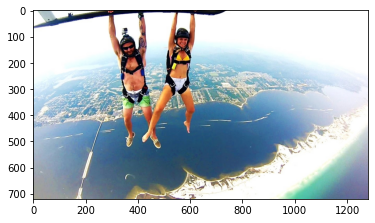


Description: mężczyzna w czerwonych kąpielowym wspina na białej


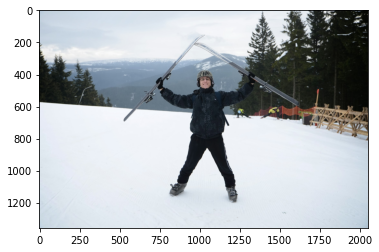


Description: mężczyzna zjeżdża na desce po


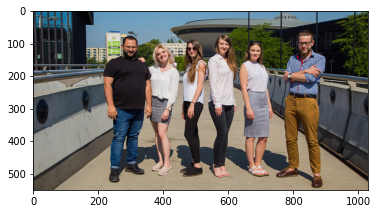


Description: grupa ludzi stoi przed


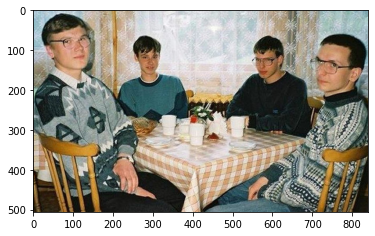


Description: rodzina siedzi przy stole w


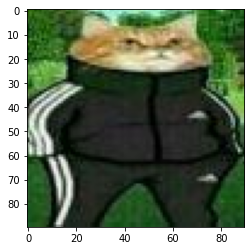


Description: kobieta w brązowej siedzi siedzi z przy


KeyboardInterrupt: 

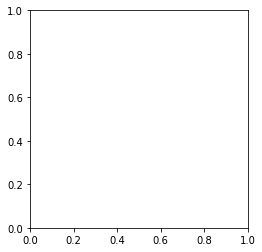

In [31]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
from textblob import TextBlob
import requests
import os
from io import BytesIO
import numpy as np
%matplotlib inline

p = os.listdir("C:/Users/Adi/Downloads/praca/test/")

for i in p:
    with open("C:/Users/Adi/Downloads/praca/test/" + i, "rb") as f:
        imgarr = f.read()
        img = Image.open(BytesIO(imgarr))
        img.load()
        plt.imshow(img)
        plt.show()
        img = encodeImage(img).reshape((1,OUTPUT_DIM))
        res = generateCaption(img)
#         translator = TextBlob(res)
#         res_t = translator.translate(to="pl")
#         from translate import Translator
#         translator = Translator(to_lang="pl")
#         translation = translator.translate(res)
        print("Description:", res)